# Chapter 1: Introduction
This chapter covers software installation and testing. We will assume that you have installed Anaconda, created the quantum environment  installed the and selected basic packages via Anaconda prompt as follows




## Installation of Python packages

> conda activate quantum <br>
> conda install python=3.11 <br>
> conda install pip <br>
> conda install matplotlib <br>

The following commands will install the necessary packages for D-Wave
> conda activate quantum <br>
> pip install dwave-system <br>
> pip install dwave-neal <br>
> pip install dwave-ocean-sdk <br>
> pip install pyqubo <br>

The following commands will install the necessary packages for Qiskit
> conda activate quantum <br>
> pip install qiskit <br>
> pip install qiskit-ibm-runtime <br>
> pip install qiskit-aer <br>
> pip install qiskit-ibmq-provider <br>


## Test Python environment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('Plot of sin(x) vs x')
plt.grid(True)
plt.show()

## Test the D-Wave installation 
Solve a max-cut graph problem using simulated annealing

In [ ]:
import neal
from pyqubo import Binary, Array
import networkx as nx

G = nx.Graph() # graph package
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])
H = 0
q = Array.create("q",shape = 5,vartype = "BINARY")
for i, j in G.edges:# create H from graph
    H = H + 2*q[i-1]*q[j-1] - q[i-1] - q[j-1] # offset by 1

model = H.compile()
bqm = model.to_bqm()
sampler = neal.SimulatedAnnealingSampler()
results = sampler.sample(bqm)
print(results)

## Test the Qiskit installation 
Create, simulate and plot a quantum circuit

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import matplotlib.pyplot as plt
circuit = QuantumCircuit(1, 1) 
circuit.h(0) # apply H to qubit 0
# measure and place result in classical bit
circuit.measure(0, 0) 

display(circuit.draw('mpl'))
backend = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(circuit, backend)
job = backend.run(transpiled_circuit,shots = 1000)
counts = job.result().get_counts(circuit)
print("Counts:\n",counts)

# Chapter 2: Quantum Annealing Strategy

Simulated annealing and quantum annealing are heuristic algorithms to solve quadratic unconstrained binary optimization (QUBO) problems, that are extremely difficult to solve using deterministic algorithms. Simulated annealing algorithms are executed on classical computers, while quantum annealing algorithms are executed on quantum machines such as the D-Wave  with several thousand qubits. 

## Import Modules for Solving QUBO

In [ ]:
from pyqubo import Binary, Array,Placeholder
from dimod.reference.samplers import ExactSolver
import neal
from dwave.system import LeapHybridSampler, DWaveSampler, EmbeddingComposite
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

##  Pose and solve a 3-variable QUBO problem using an exact solver.

$$ \min_{\{a,b,c\}}  (0.6 a b +0.2 a c + 0.03 b c - 0.1 a - 0.5 b - 0.2c ) $$

In [ ]:
a,b,c = Binary("a"), Binary("b"),Binary("c")
H  = 0.6*a*b +0.2*a*c + 0.03*b*c -0.1*a - 0.5*b -0.2*c
model = H.compile()
bqm = model.to_bqm()
# using exact solver for small problems
sampler = ExactSolver() 
results = sampler.sample(bqm)
print(results)

## Max-cut graph QUBO problem using Exact solver

In [ ]:
G = nx.Graph() # convenient
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])
H = 0
q = Array.create("q",shape = 5,vartype = "BINARY")
for i, j in G.edges:# create H from graph
    H = H + 2*q[i-1]*q[j-1] - q[i-1] - q[j-1] # offset by 1

model = H.compile()
bqm = model.to_bqm()
# using exact solver for small problems
sampler = ExactSolver()  
results = sampler.sample(bqm)
print(results)

##  Solve using Simulated Annealing

In [ ]:
sampler = neal.SimulatedAnnealingSampler()
results = sampler.sample(bqm)
print(results)

##  Solve a constrained graph problem 
Via the Lagrangian multiplier, using an Exact QUBO solver.

In [ ]:
G = nx.Graph() # convenient
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])
H = 0
q = Array.create("q",shape = 5,vartype = "BINARY")
for i, j in G.edges:# create H from graph
    H = H + 2*q[i-1]*q[j-1] - q[i-1] - q[j-1] # offset by 1
lam = 100
H = H + lam*(q[0] + q[3]-1)**2
model = H.compile()
bqm = model.to_bqm()
# using exact solver for small problems
sampler = ExactSolver()  
results = sampler.sample(bqm)
print(results)

## QUBO Box Solver

In [ ]:
class QUBOBoxSolverClass:
	def __init__(self,beta=0.5,LBox0 = 1,tol = 1e-6,
			  samplingMethod = "simulatedAnnealing", 
			  nSamples = 50,boxMaxIteration = 100):	
		
		self.beta = beta
		self.LBox0 = LBox0
		self.boxMaxIteration = boxMaxIteration
		self.relativeTolerance = tol
		self.samplingMethod = samplingMethod #  exact, simulatedAnnealing, quantumAnnealing
		self.nSamples = nSamples # not relevant for symbolic sampling method
		if (self.samplingMethod == "exact"):
			self.sampler = ExactSolver()
		elif (self.samplingMethod == "simulatedAnnealing"):
			self.sampler = neal.SimulatedAnnealingSampler(); #SimulatedAnnealingSampler()
		elif (self.samplingMethod == "hybridQuantumAnnealing"):
			self.sampler = LeapHybridSampler()       
		elif (self.samplingMethod == "quantumAnnealing"):
			self.sampler = EmbeddingComposite(DWaveSampler())      
		else:
			print("Invalid sampling method")

		self.nQubitsPerDimension = 2 # don't change
		
	def modelWithPlaceHolders(self):
		# When using PyQUBO, creating a self.model with place holers avoids repeated compiling
		q = self.matrixSize*[None]
		for i in range(self.matrixSize):
			q[i] = Array.create("q[" + str(i)+"]",shape = self.nQubitsPerDimension,vartype = "BINARY")
		c = self.matrixSize*[0]#placeholders
		b = self.matrixSize*[0]#placeholders
		A = self.matrixSize*[0]#placeholders
		x = self.matrixSize*[0]# symbolic via qubits  
		for i in range(self.matrixSize):
			A[i] = self.matrixSize*[0]#placeholders		  
		L = Placeholder('L')
		for i in range(self.matrixSize):
			c[i] = Placeholder('c[%d]' %i)
			b[i] = Placeholder('b[%d]' %i)
			for j in range(self.matrixSize):
				A[i][j] = Placeholder("A[{i}][{j}]".format(i = i, j = j))      
		for i in range(self.matrixSize):
			x[i] = c[i] + L*(-2*q[i][0] + q[i][1])
		   
		H = 0
		for  i in range(self.matrixSize):
			Ax = 0
			for j in range(self.matrixSize):
				Ax = Ax + A[i][j]*x[j]    
			H = H + x[i]*(0.5*Ax) - x[i]*b[i]
		self.model = H.compile()
		return self.model
	
	def plotBox(self,center,L,iteration):
		if (self.matrixSize != 2): # only plot for this case
			return
	   
		plotColors = ['k','r','b','g','c','m','y']
		index = iteration % len(plotColors)
		xBox = [center[0]-2*L, center[0]+L,center[0]+L,center[0]-2*L,center[0]-2*L ]
		yBox = [center[1]-2*L, center[1]-2*L, center[1]+L, center[1]+L,center[1]-2*L]
		plt.plot(xBox,yBox,plotColors[index])  
	 
		plt.savefig("./results/" + str(iteration) +".png")
		
	def QUBOBoxSolve(self,A, b,xGuess = [],debug = False):
		self.matrixSize = A.shape[0]
		self.model = self.modelWithPlaceHolders()
		qSol = self.matrixSize*[None]
		for i in range(self.matrixSize):
			qSol[i] = self.nQubitsPerDimension*[0]
		if (len(xGuess) == 0 ):
			center = self.matrixSize*[0]#numerical
		else:
			center = xGuess
		self.modelDictionary = {}
		for  i in range(self.matrixSize):
			self.modelDictionary['b[%d]' %i] = b[i]
			for j in range(self.matrixSize):
				self.modelDictionary["A[{i}][{j}]".format(i = i, j = j)] = A[i,j]  
		L = self.LBox0
		boxSuccess = True
		nTranslations = 0
		nContractions = 0
		PEHat = 0
		for iteration in range(self.boxMaxIteration):
			#print('Boxiteration:', iteration, L/self.LBox0)
			if (L/self.LBox0 < self.relativeTolerance):
				break
			if (iteration == self.boxMaxIteration):
				break
			self.modelDictionary['L'] =  L
			for  i in range(self.matrixSize):
				self.modelDictionary['c[%d]' %i] = center[i]    
			bqm = self.model.to_bqm(feed_dict = self.modelDictionary)
			if (self.samplingMethod == "exact"):
				results = self.sampler.sample(bqm)
			elif (self.samplingMethod == "simulatedAnnealing"):
				results = self.sampler.sample(bqm, num_reads=self.nSamples)
			elif (self.samplingMethod == "openjijAnnealing"):
				results = self.sampler.sample(bqm, num_reads=self.nSamples)
			elif (self.samplingMethod == "quantumAnnealing"):
				results = self.sampler.sample(bqm)
 
			sample = results.first.sample
			PEStar = results.first.energy 
				
			if (PEStar < PEHat*(1+1e-8)):# Center has moved
				for i in range(self.matrixSize):		
					qSol[i][0]= sample["q["+str(i)+"][0]"]
					qSol[i][1]= sample["q["+str(i)+"][1]"]
				PEHat = PEStar
				for i in range(self.matrixSize):  
					center[i] = center[i] + L*(-2*qSol[i][0] + qSol[i][1])			  
				nTranslations = nTranslations + 1
			else:# Contraction only if we don't translate
				L = L*self.beta
				nContractions = nContractions + 1
			if(debug):
				self.plotBox(center,L,iteration)
				print('Iter: ' + str(iteration)  + '; center: ' + str(center) + '; PE: ' + str(PEStar) + '; L: ' + str(L))
		if ( L/self.LBox0  > self.relativeTolerance):
			print("Box method did not converge to desired tolerance")
			boxSuccess = False
	
		return [np.array(center),L,iteration,boxSuccess,nTranslations,nContractions,results]


## Box algorithm to solve the linear system of equations
$$ \mathbf {A} \mathbf {x} = \mathbf {b} $$ 
$$ \mathbf {A} =  \begin{bmatrix}
            6 & -6 & 0 & 0 & 0 \\
             -6 & 12 & -6 & 0 & 0 \\
            0 & -6 & 12 & -6 & 0 \\
            0 & 0 & -6 & 12 & -6 \\
             0 & 0 & 0 & -6 & 12 \\
            \end{bmatrix} $$
$$ \mathbf {b}  = \mathbf {A} \begin{pmatrix} \pi/3 \\ -1/2 \\ 1/3 \\ \pi/10 \\ 0.1 \\0.5 \end{pmatrix} $$


In [ ]:

A = np.array([[6,-6,0,0,0,0],[-6,12,-6,0,0,0],[0,-6,12,-6,0,0],[0,0,-6,12,-6,0],
		      [0,0,0,-6,12,-6],[0,0,0,0,-6,12]])
xExact = np.array([np.pi/3,-1/2,1/3,-np.pi/10,0.1,0.5 ])
b = A.dot(xExact)

QB = QUBOBoxSolverClass(
	beta=0.5,
	LBox0=1,
	tol=1e-8,
	samplingMethod="simulatedAnnealing",
	nSamples=100,
	boxMaxIteration=100
	)

xSolution, LHistory1, nIterations, _, _, _, _ = QB.QUBOBoxSolve(A, b)
print("xExact:", xExact)
print("xSolution:", xSolution)
print("*" * 50)

# Chapter 3: Qubits

In this chapter, we will create qubits and execute quantum circuits

##  Creating complex numbers

In [ ]:
from IPython.display import display, HTML
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
#%% Complex variables
x = 1 + 3j # note the 3j
print("The real part is: ", x.real)
print("The imaginary part is: ", x.imag)
print("The absolute value is: ", abs(x))

## Creating and displaying qubits

In [ ]:
ket0 = Statevector([1, 0]) # define ket 0
ket1 = Statevector([0, 1]) # define ket 1

phi = 1/np.sqrt(2)*ket0 +   1j/np.sqrt(2)*ket1
display(phi.draw('latex'))

psi =  Statevector([1/np.sqrt(2), 1j/np.sqrt(2),0,0]) 
display(psi.draw('latex'))

print(psi.is_valid())

## Creating kets using labels

In [ ]:
ket0 = Statevector.from_label('0')# define ket 0
ket1 = Statevector.from_label('1') # define ket 1

phi = (1/2)*Statevector.from_label('00') + (np.sqrt(3)/2)*Statevector.from_label('11')
display(phi.draw('latex'))

## Inner products of qubits

In [ ]:
psi =  Statevector([-1j/np.sqrt(2), 0,0, 1/np.sqrt(2)]) 
phi =  Statevector([-1j/np.sqrt(2), (np.sqrt(3)-1j)/4,0, 1/2]) 
display(psi.draw('latex'))
display(phi.draw('latex'))
print(psi.inner(phi))

## Tensor products of qubits

In [ ]:
ket0 = Statevector([1, 0]) # define ket 0
ket1 = Statevector([0, 1]) # define ket 1

ket00 = ket0.tensor(ket0)
ket01 = ket0.tensor(ket1)
ket10 = ket1.tensor(ket0)
ket11 = ket1.tensor(ket1)

phi = 1/2*ket00 +   1j/np.sqrt(2)*ket10 +  (np.sqrt(3)+1j)/4*ket11

display(phi.draw('latex'))
psi = phi.tensor(phi)
display(psi.draw('latex'))

# Chapter 4: Quantum Operators and Circuit

In this chapter, we will create and work with quantum operators and circuits

## Import modules

In [ ]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from IPython.display import display
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library.standard_gates.u import UGate
from qiskit_aer import Aer
import numpy as np

## Function to simulate a circuit

In [18]:
def simulateCircuit(circuit,nShots=1000):
	backend = Aer.get_backend('qasm_simulator')
	new_circuit = transpile(circuit, backend)
	job = backend.run(new_circuit,shots = nShots)
	counts = job.result().get_counts(circuit)
	return counts

## Hadamard circuit

In [ ]:
circuit = QuantumCircuit(1) # 1 qubit
circuit.h(0) # apply H to qubit 0
display(circuit.draw('mpl'))
psi = Statevector(circuit) #extract the state
display(psi.draw('latex')) # print

## Simulating the Hadamard circuit

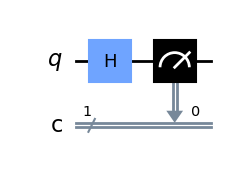

Counts: {'1': 492, '0': 508}


In [21]:
circuit = QuantumCircuit(1, 1) 
circuit.h(0) # apply H to qubit 0
# measure and place result in classical bit
circuit.measure(0, 0) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)

## Operators X and H in sequence

In [ ]:
circuit = QuantumCircuit(1, 1)  
circuit.x(0) 
circuit.h(0) 
circuit.measure(0, 0) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)

## State preparation

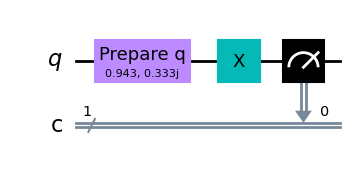

Counts: {'1': 904, '0': 96}


In [22]:
circuit = QuantumCircuit(1, 1)  
q = Statevector([np.sqrt(8)/3, (1j)/3]) 
circuit.prepare_state(q,0,'Prepare q')
circuit.x(0) 
circuit.measure(0, 0) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)


## Multi-qubit circuit

In [ ]:
circuit = QuantumCircuit(3, 3)  
circuit.x(0)
circuit.id(1)
circuit.h(2)
circuit.measure([0,1,2], [0,1,2]) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)

## Multi-qubit, theoretical state

In [ ]:
circuit = QuantumCircuit(3, 3)  
circuit.x(0)
circuit.id(1)
circuit.h(2)
psi = Statevector(circuit)
display(psi.draw('latex'))

## Unitary operator

In [ ]:
circuit = QuantumCircuit(1, 1) 
UMatrix = 1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]) 
circuit.unitary(UMatrix,0,'myU')
circuit.measure(0,0) 
# To see the theoretical state, comment the previous line and uncomment next 2 lines
# psi = Statevector(circuit)
# display(psi.draw('latex'))
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)

## Universal operator

In [26]:
def UniversalOperator(theta,phi,lambdaAngle):
	U = np.array([[np.cos(theta/2),-np.exp(1j*lambdaAngle)*np.sin(theta/2)],
			      [np.exp(1j*phi)*np.sin(theta/2), np.exp(1j*(phi+lambdaAngle))*np.cos(theta/2)]])
	return U

U = UniversalOperator(np.pi/2,np.pi,np.pi)
print(U)
U = UniversalOperator(np.pi,0,0)
print(U)

[[ 0.70710678+0.00000000e+00j  0.70710678-8.65956056e-17j]
 [-0.70710678+8.65956056e-17j  0.70710678-1.73191211e-16j]]
[[ 6.123234e-17+0.j -1.000000e+00-0.j]
 [ 1.000000e+00+0.j  6.123234e-17+0.j]]


## CNOT Operator

In [ ]:
circuit = QuantumCircuit(2, 2)  
circuit.x(1) # try id(1), h(1)
circuit.cx(1,0)
circuit.measure([0,1], [0,1]) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)

## Unitary operator of a circuit

In [ ]:
circuit = QuantumCircuit(2, 2)  
circuit.cx(1,0)
U = Operator(circuit)
print("U: \n", U.data)

## Controlled Hadamard

In [ ]:
circuit = QuantumCircuit(2, 2)  
circuit.x(1) # try id(1), h(1)
circuit.ch(1,0)
circuit.measure([0,1], [0,1]) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)

## CNOT and Controlled Hadamard

In [ ]:
circuit = QuantumCircuit(3, 3) 
circuit.y(0) 
circuit.rx(np.pi/3,1) 
circuit.h(2) 
circuit.barrier()
circuit.cx(2,0)
circuit.ch(2,1)
circuit.measure([0,1,2], [0,1,2]) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,10000)
print('Counts:',counts)
plot_histogram(counts)

## Controlled Phase

In [ ]:
circuit = QuantumCircuit(2, 2)  
circuit.x(0) 
circuit.x(1) 
circuit.cp(-np.pi/2,0,1)
psi = Statevector(circuit)
display(psi.draw('latex'))

circuit.measure([0,1], [0,1]) 
display(circuit.draw('mpl') )
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)

## Controlled Phase with Hadamard

<IPython.core.display.Latex object>

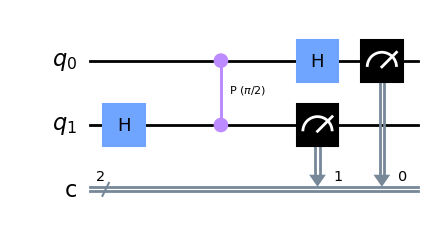

Counts: {'01': 252, '11': 236, '10': 269, '00': 243}


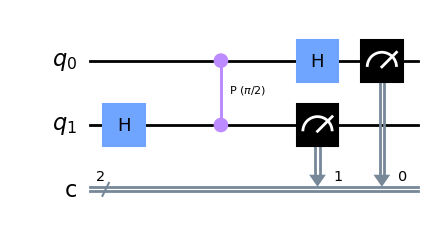

In [ ]:
circuit = QuantumCircuit(2, 2)  
circuit.h(1) 
circuit.cp(np.pi/2,0,1)
circuit.h(0) 
psi = Statevector(circuit)
display(psi.draw('latex'))

circuit.measure([0,1], [0,1]) 
display(circuit.draw('mpl')) 
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)


## Simple Swap

In [ ]:
circuit = QuantumCircuit(2, 2)  
circuit.x(1) 
circuit.swap(1,0)
circuit.measure([0,1], [0,1]) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)


## Controlled Unitary

In [ ]:
circuit = QuantumCircuit(2, 2) 
UMatrix = 1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]) 
U = UnitaryGate(UMatrix,'myU')
UControl = U.control(1)
circuit.append(UControl,[1,0])
psi = Statevector(circuit) #extract the state
display(psi.draw('latex')) # print
circuit.measure([0,1],[0,1]) 
display(circuit.draw('mpl'))

## State-controlled U Gate

In [ ]:
circuit = QuantumCircuit(4, 1) 
cu_gate = UGate(np.pi, 0, 0).control(3, ctrl_state = '101')
# Not sure why the following does not work
# circuit.cry(theta = np.pi/3,target_qubit= 0,
#      control_qubit = [1,2,3], ctrl_state = '101')
circuit.append(cu_gate,[1,2,3,0])
circuit.measure([0],[0]) 
display(circuit.draw('mpl') )


## Hadamard Test

In [ ]:
zeroQubit = QuantumRegister(1, '0')
phiQubit = QuantumRegister(1, '\u03D5')
cl = ClassicalRegister(1,'m')
circuit = QuantumCircuit(zeroQubit,phiQubit, cl) 
circuit.h(0)
#circuit.sdg(0)
UMatrix = 1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]) 
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)

## Inner Product

In [ ]:
circuit = QuantumCircuit(2, 1) 
circuit.h(0)
a = np.sqrt(3)
b = 1/np.sqrt(2)
UMatrix = b*np.array([[(a+1)/2,(a-1)/2],[(a-1)/2,(-a-1)/2]])
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,100)
print('Counts:',counts)

## Inner Product-Real

In [ ]:
def ryMatrix(alpha):
	return np.array([[np.cos(alpha/2), -np.sin(alpha/2)], [np.sin(alpha/2), np.cos(alpha/2)]])
	
U_phi = ryMatrix(2*np.pi/3)
U_psi = ryMatrix(np.pi/3)
UMatrix = np.matmul(U_phi.conj().T,U_psi)

circuit = QuantumCircuit(2, 1) 
circuit.h(0)
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
nShots = 10000
counts = simulateCircuit(circuit,nShots)

dotprod = 2*counts['0']/nShots - 1
print('dotprod:',dotprod)

## Inner product: Imaginary

In [28]:
def ryMatrix(alpha):
	return np.array([[np.cos(alpha/2), -np.sin(alpha/2)], [np.sin(alpha/2), np.cos(alpha/2)]])

def rzMatrix(omega):
	return np.array([[np.exp(-1j*omega/2), 0], [0, np.exp(1j*omega/2)]])
	
	
U_phi = ryMatrix(2*np.pi/3)
U_psi = rzMatrix(-np.pi)
UMatrix = np.matmul(U_phi.conj().T,U_psi)
phi = np.matmul(U_phi,np.array([1,0]))
psi = np.matmul(U_psi,np.array([1,0]))
print('Exact:', np.dot(phi,psi))

circuit = QuantumCircuit(2, 1) 
circuit.h(0)
circuit.sdg(0)
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
circuit.draw('mpl')
nShots = 10000
counts = simulateCircuit(circuit,nShots)

dotprod = (counts['0'] - counts['1'])/nShots
print('dotprod:',dotprod)

Exact: (3.0616169978683836e-17+0.5000000000000001j)


NameError: name 'UnitaryGate' is not defined

## Inner product: Negative Real

In [ ]:
def ryMatrix(alpha):
	return np.array([[np.cos(alpha/2), -np.sin(alpha/2)], [np.sin(alpha/2), np.cos(alpha/2)]])
	
U_phi = ryMatrix(2*np.pi/3)
U_psi = ryMatrix(5*np.pi/2)

phi = np.matmul(U_phi,np.array([1,0]))
psi = np.matmul(U_psi,np.array([1,0]))
print('Exact:', np.dot(phi,psi))
UMatrix = np.matmul(U_phi.conj().T,U_psi)

circuit = QuantumCircuit(2, 1) 
circuit.h(0)
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
nShots = 10000
counts = simulateCircuit(circuit,nShots)

dotprod = (counts['0'] - counts['1'])/nShots
print('dotprod:',dotprod)

## Swap test concept

In [ ]:
zeroQubit = QuantumRegister(1, '0')
psiQubit = QuantumRegister(1, '\u03C8')
phiQubit = QuantumRegister(1, '\u03D5')
cl = ClassicalRegister(1,'m')
circuit = QuantumCircuit(zeroQubit,phiQubit,psiQubit,cl) 
circuit.h(0)

circuit.cswap(zeroQubit, psiQubit, phiQubit)
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl')) 


## Swap test example

In [ ]:
circuit = QuantumCircuit(3,1) 
circuit.h(0)
circuit.ry(2*np.pi/3, 1)
circuit.h(2)
circuit.cswap(0, 1, 2)
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl')) 
counts = simulateCircuit(circuit,10000)
print('Counts:',counts)

P0 = (counts['0'])/10000
print('dotprodSqr:',2*P0-1)

# Chapter 5: Quantum Fourier Transform

In this chapter, we will study Quantum Fourier Transform (QFT), an extremely useful quantum algorithm, and its
quantum circuit implementation. QFT is the quantum equivalent of Discrete Fourier Transform (DFT), and plays
a vital role in many applications, including the solution of quantum phase estimation, Shor’s algorithm, machine
learning, etc. We will briefly review digital signals and their processing as a motivation to QFT.

## Import packages

In [ ]:
from qiskit.circuit.library import QFT

np.set_printoptions(precision =3,suppress=True)

## Continuous Signal

In [ ]:
def continuousSignal(t):
	example = 3
	if (example == 1):
		s = 0.5*np.sin(2*2*np.pi*t) 
	elif (example == 2):
		s = 0.5*np.sin(2*2*np.pi*t) - 0.3*np.cos(5*2*np.pi*t)
	else:
		s = 0.25 + 0.5*np.sin(2*2*np.pi*t) - 0.3*np.cos(5*2*np.pi*t)
	return s

nContinuousSamples = 1000 # for plotting
tPlot = np.linspace(0,1,nContinuousSamples,endpoint = False)
yPlot = continuousSignal(tPlot)

M = 32 # We set the number of discrete samples here
t = np.linspace(0,1,M,endpoint = False) # need to eliminate the last point
y = continuousSignal(t)

plt.plot(tPlot,yPlot)
plt.axhline(0, color='black')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Signal', fontsize=14)
plt.grid(visible=True)


plt.figure()
plt.axhline(0, color='black')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Signal', fontsize=14)
plt.grid(visible=True)
plt.plot(t,y,'*')

## DFT Signal Processing

In [ ]:
def createDFTMatrix(M):
    DFTMatrix = np.zeros((M,M), dtype=complex)
    omega = np.exp(1j*(2*np.pi/M))
    for i in range(M):
        for j in range(M):
            DFTMatrix[i][j] = omega**(-i*j)
    return DFTMatrix 

M = len(y)
DFTMatrix = createDFTMatrix(M)
phi = np.matmul(DFTMatrix,y)
# Process DFT Result
def processDFTResult(phi):
	M = len(phi)
	phi = phi/M
	c0 =  phi[0].real # constant
	a = (phi[1:int(M/2)]).real+(phi[M-1:int(M/2):-1]).real; # cosine terms
	b =  (phi[M-1:int(M/2):-1] - phi[1:int(M/2)]).imag; # sine terms
	b = np.insert(b, 0,0)
	return [c0,a,b]

[c0,a,b] = processDFTResult(phi)

plt.figure()
plt.bar(0,c0, label =r"$c_0$")
plt.bar(list(range(1,int(M/2))),a, label =r"$a_i$")
plt.bar(list(range(0,int(M/2))),b, label =r"$b_i$")
plt.legend( fontsize=14)
plt.axhline(0, color='black')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)

## QFT with 2 qubits

In [ ]:
circuit = QuantumCircuit(2, 2)  
circuit.h(1)
circuit.cp(np.pi/2,0,1) 
circuit.h(0) 
circuit.swap(0,1)
print(np.array(Operator(circuit).data))
circuit.measure([0,1], [0,1]) 
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)
circuit.draw('mpl') 

## QFT with 3 qubits

In [ ]:
m = 3 # number of qubits
circuit = QuantumCircuit(m, m) 
qft = QFT(num_qubits=m).to_gate()
circuit.append(qft, qargs=list(range(m)))
circuit.measure(list(range(m)),list(range(m))) 
circuit.decompose(reps=2).draw('mpl') 

## QFT from scratch

In [ ]:
def myQFT(m): # m is the # of qubits
    q = QuantumRegister(m, 'q')
    c = ClassicalRegister(m,'c')
    circuit = QuantumCircuit(q,c)
    for k in range(m):
        j = m - k
        circuit.h(q[j-1])
        circuit.barrier()
        for i in reversed(range(j-1)):
            circuit.cp(2*np.pi/2**(j-i),q[i], q[j-1])
      
    circuit.barrier()  
    for i in range(m//2):
        circuit.swap(q[i], q[m-i-1])
    return circuit

m = 3
circuit = myQFT(m)
circuit.measure(list(range(m)),list(range(m))) 
circuit.draw('mpl') 

QFT Matrix Verification

In [ ]:
def createQFTMatrix(M):
    QFTMatrix = np.zeros((M,M), dtype=complex)
    omega = np.exp(2*np.pi*1j/M)
    for i in range(M):
        for j in range(M):
            QFTMatrix[i][j] = omega**(i*j)
    return QFTMatrix/np.sqrt(M)

m = 3
circuit = myQFT(m)
UFromCircuit = Operator(circuit)
UExact = createQFTMatrix(2**m)
print("Error: ", round(np.linalg.norm(UFromCircuit-UExact),10))

## QFT Signal Processing

In [ ]:
def QFTSignalProcessing(y,nShots):
	M = len(y) # length of signal
	m = int(np.log2(M)) # number of qubits
	circuit = QuantumCircuit(m, m)  
	q = Statevector(y/np.linalg.norm(y)) 
	circuit.prepare_state(q,list(range(m)),'Prepare q')
	qftCircuit = myQFT(m)
	circuit.append(qftCircuit, qargs=list(range(m)),cargs=list(range(m)))
	circuit.measure(list(range(m)),list(range(m))) 
	counts = simulateCircuit(circuit,nShots=nShots)
	return counts

nShots = 1000
counts = QFTSignalProcessing(y,nShots)
plot_histogram(counts)

## Process QFT results

In [ ]:
def processQFTResult(counts,nShots):
	phi = np.zeros(M)
	for i in counts:
		freq = int(i, 2)
		phi[freq] = np.sqrt(counts[i]/nShots)
	ampl = (phi[1:int(M/2)])+(phi[M-1:int(M/2):-1]);
	ampl = np.insert(ampl, 0,phi[0].real)
	return ampl
	
ampl = processQFTResult(counts,nShots)

plt.figure()
plt.bar(list(range(0,int(M/2))),ampl)
plt.axhline(0, color='black')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)

## QFT Signal Processing

In [ ]:
M = len(y) # length of signal
m = int(np.log2(M)) # number of qubits
circuit = QuantumCircuit(m, m)  
yNormalized = y/np.linalg.norm(y)
q = Statevector(yNormalized) 
circuit.prepare_state(q,list(range(m)),'Prepare q')
qft = QFT(num_qubits=m).to_gate()
circuit.append(qft, qargs=list(range(m)))
circuit.measure(list(range(m)),list(range(m))) 
nShots = 1000
counts = simulateCircuit(circuit,nShots=nShots)
print('Counts:',counts)
plot_histogram(counts)
qftResult = np.zeros(2**(m-1))
for i in counts:
	freq = int(i, 2)
	if (freq > (2**m)/2):
		freq = (2**m)-freq
	ampl = counts[i]/nShots
	qftResult[freq] = qftResult[freq] + ampl

print(qftResult)

## QFT with 3 qubits

In [ ]:
m = 3 # number of qubits
circuit = QuantumCircuit(m, m) 
circuit.x(0)
circuit.x(1)
circuit.x(2)
qft = QFT(num_qubits=m).to_gate()
circuit.append(qft, qargs=list(range(m)))
psi = Statevector(circuit)
display(psi.draw('latex'))

## Inverse QFT with 3 qubits

In [ ]:
m = 3 # number of qubits
circuit = QuantumCircuit(m, m) 
iqft = QFT(num_qubits=m,inverse=True).to_gate()
iqft._name = 'IQFT'
circuit.append(iqft, qargs=list(range(m)))

psi = Statevector(circuit)
display(psi.draw('latex'))
circuit.draw('mpl') 

# Chapter 6: Quantum Phase Estimation

Quantum phase estimation (QPE), a second fundamental algorithm in quantum computing. QPE is a critical component of various QC algorithms. The main objective of QPE is, given an eigenvector of a (typically unitary) matrix, to estimate the
corresponding eigenvalue. 

## Import packages

In [ ]:
from qiskit.circuit.library import HamiltonianGate
from qiskit.circuit.library import QFT, PhaseEstimation, UnitaryGate

## Hamiltonian

In [ ]:
A = np.array([[2,-1],[-1,2]])
f = 0.5
lambdaUpper = 3
t = -2*np.pi*f/lambdaUpper #Note negative
U_A = HamiltonianGate(A, time=t,label = 'UA')
print(np.array(U_A.to_matrix()))
v = np.array([1/np.sqrt(2),-1/np.sqrt(2)])
circuit = QuantumCircuit(1)
circuit.prepare_state(Statevector(v) ,0,'Prepare v')
circuit.append(U_A, qargs=[0])
psi = Statevector(circuit)
display(psi.draw('latex'))
circuit.draw('mpl') 

## Markdown

In [ ]:
zeroQubit = QuantumRegister(1, '0')
vQubit = QuantumRegister(1, 'v')
circuit = QuantumCircuit(zeroQubit,vQubit) 
circuit.h(0)
UMatrix = 1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]) 
U = UnitaryGate(UMatrix,'U_A')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.draw('mpl') 

## Probability Model

In [ ]:
zeroQubit = QuantumRegister(1, '0')
vQubit = QuantumRegister(1, 'v')
cBit = ClassicalRegister(1, 'c')
circuit = QuantumCircuit(zeroQubit,vQubit,cBit) 
circuit.h(0)
UMatrix = 1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]) 
U = UnitaryGate(UMatrix,'U_A')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure([0], [0]) 
circuit.draw('mpl') 


## Single digit QPE with multiple qubits v

In [ ]:
def myQPESingleBit(A,v,lambdaUpper,nShots=1000):
	n = int(np.log2(v.shape[0]))
	circuit = QuantumCircuit(n+1,1)
	circuit.h(0)
	circuit.prepare_state(Statevector(v),[*range(1, n+1)],'v')
	t = -2*np.pi/lambdaUpper #Note negative
	U_A = HamiltonianGate(A, time=t,label = 'UA')
	UControl = U_A.control(1) # only 1 control qubit
	circuit.append(UControl,[*range(0, n+1)])
	circuit.h(0)
	circuit.measure([0], [0]) 
	counts = simulateCircuit(circuit,nShots)
	probabilities = np.array([])
	thetaEstimates = np.array([])
	countsSorted = {k: v for k, v in sorted(counts.items(), 
										 key=lambda item: item[1],
										 reverse=True)}
	for key in countsSorted:
		probabilities = np.append(probabilities,countsSorted[key]/nShots)
		thetaEstimates = np.append(thetaEstimates,int(key, 2)/(2))
	return [thetaEstimates,probabilities]

## Multiple digit QPE 

In [ ]:
def myQPEMultiBit(A,v,lambdaUpper,m,nShots=10):
	N = v.shape[0]
	n = int(np.log2(N))
	phase_qubits = QuantumRegister(m, '\u03B8')
	input_qubits = QuantumRegister(n, 'v')
	phase_measurements = ClassicalRegister(m, '\u0398')
	circuit = QuantumCircuit(phase_qubits,input_qubits,phase_measurements)
	for i in range(m):
		circuit.h(i)
	circuit.prepare_state(Statevector(v),[*range(m, n+m)],'v')
	t = -2*np.pi/lambdaUpper #Note negative
	U_A = HamiltonianGate(A, time=t,label = 'UA')
	U_A._name = 'UA'
	for i in range(m):
		U_A_pow = U_A.power(2**i) 
		UControl = U_A_pow.control(1) # only 1 control qubit
		circuit.append(UControl,[i,*range(m, n+m)])
	iqft = QFT(num_qubits=m,inverse=True).to_gate()
	iqft._name = 'IQFT'
	circuit.append(iqft, [*range(0,m)])
	circuit.measure([*range(0,m)], [*range(0,m)]) 
	circuit.draw('mpl') 
	counts = simulateCircuit(circuit,nShots)
	print(counts)
	countsSorted = {k: v for k, v in sorted(counts.items(), 
										 key=lambda item: item[1],
										 reverse=True)}
	probabilities = np.array([])
	thetaEstimates = np.array([])
	for key in countsSorted:
		probabilities = np.append(probabilities,countsSorted[key]/nShots)
		thetaEstimates = np.append(thetaEstimates,int(key, 2)/(2**m))
	return [thetaEstimates,probabilities]

## QPE Example 1

In [ ]:
A = np.array([[1,0],[0,0.75]])
v0 = np.array([0,1])
v1 = np.array([1,0])
Lambda = [0.75,1]
a = [1/np.sqrt(2),1/np.sqrt(2)]
a= [1,0]
v = a[0]*v0 + a[1]*v1
lambdaUpper = 2
m = 2

[thetaEstimates,P] = myQPESingleBit(A,v,lambdaUpper)	
print("thetaEstimates:",thetaEstimates)
print("probabilities:", P)
thetaTilde = np.sum(thetaEstimates*P)
print("thetaTilde:", thetaTilde)
print("EigenvalueTilde:",thetaTilde*lambdaUpper)

## QPE Example 2

In [ ]:
A = np.array([[2,-1],[-1,2]])
v0 = np.array([1/np.sqrt(2),1/np.sqrt(2)])
v1 = np.array([1/np.sqrt(2),-1/np.sqrt(2)])
Lambda = [1,3]
a = [1,0]
v = a[0]*v0 + a[1]*v1
lambdaUpper = 6
m = 2

[thetaEstimates,P] = myQPESingleBit(A,v,lambdaUpper)	
print("thetaEstimates:",thetaEstimates)
print("probabilities:", P)
thetaTilde = np.sum(thetaEstimates*P)
print("thetaTilde:", thetaTilde)
print("EigenvalueTilde:",thetaTilde*lambdaUpper)

## QPE Example 3

In [ ]:
A = np.array([[1,0,0,-0.5],[0,1,0,0],[0,0,1,0],[-0.5,0,0,1]])
v0 = np.array([1/np.sqrt(2),0,0,1/np.sqrt(2)])
v1 = np.array([0,1,0,0])
v2 = np.array([0,0,1,0])
v3 = np.array([1/np.sqrt(2),0,0,-1/np.sqrt(2)])
Lambda = [0.5,1,1,1.5]
#a = [1/np.sqrt(4),1/np.sqrt(4),1/np.sqrt(4),1/np.sqrt(4)]
a = [0,0,1,0]
v = a[0]*v0 + a[1]*v1 + a[2]*v2 + a[3]*v3
lambdaUpper = 3
m = 2
[thetaEstimates,P] = myQPESingleBit(A,v,lambdaUpper)	
print("thetaEstimates:",thetaEstimates)
print("probabilities:", P)
thetaTilde = np.sum(thetaEstimates*P)
print("thetaTilde:", thetaTilde)
print("EigenvalueTilde:",thetaTilde*lambdaUpper)

## Using the built-in QFT

In [ ]:
m = 3
A = np.array([[2,-1,0,0],[-1,2,-1,0],[0,-1,2,-1],[0,0,-1,2]])
v = np.random.rand(4)
v = v/np.linalg.norm(v)
f = 0.5
lambdaUpper = 4

t = -2*np.pi*f/lambdaUpper #Note negative
U_A = HamiltonianGate(A, time=t,label = 'UA')
iqft = QFT(num_qubits=m,inverse=True).to_gate()
iqft._name = 'IQFT'
qpe = PhaseEstimation(m,U_A,iqft)


# Chapter 7: HHL Algorithm

This chapter is on the Harrow-Hassidim-Lloyd (HHL) algorithm strategy for solving the quantum linear system prob-
lem (QLSP).

In [ ]:
import scipy

class myHHL:
	# This is the hybrid version of the HHL algorithm where we explicitly 
	# construct and simulate the QPE circuit. The results are the used in 
	# the  HLL circuit
	def __init__(self, A, b, lambdaUpper,
			  m = 3,P0 = 0.1,nShots = 1000):	
		self.A = A
		self.b = b
		self.lambdaUpper = lambdaUpper # Used in Hamiltonian evolution. 
		self.m = m # Number of bits to estimate the eigenphasess
		self.nHHLShots = nShots # for simulating HHL circuit
		self.nQPEShots = nShots # for simulating QPE circuit
		self.N = self.A.shape[0]
		self.n = int(np.log2(self.N)) # number of qubits to capture b
		self.dataOK = True
		self.probabilityCutoff = P0 # for pruning QPE eigenphases
		if np.abs(2**self.n - self.A.shape[0]) > 1e-10: 
			print("Invalid size of matrix; must be power of 2") 
			self.dataOK = False
		if (self.n > 4):
			print('Matrix size is too large')
			self.dataOK = False
		symErr = np.max(self.A - np.transpose(self.A))
		if (symErr > 0):
			print('A does not appear to be symmetric')
			self.dataOK = False
		if (not np.isclose(np.linalg.norm(b), 1.0)):
			print('b does not appear to be of unit magnitude')
			self.dataOK = False
		if (m < 1):
			print('m has to be at least 1')
			self.dataOK = False
		if not (A.shape[0] == b.shape[0]):
			print('A and b sizes are not compatible')
			self.dataOK = False
			
		self.debug = False
	
	def solveuExact(self):
		# used for verification and not part of HHL
		self.xExact = scipy.linalg.solve(self.A, self.b)
		self.uExact = self.xExact/np.linalg.norm(self.xExact)

	def computeEigen(self):
		# used for verification and not part of HHL
		self.eig_val, self.eig_vec = scipy.linalg.eig(self.A)
		# Since A is assumed to be symmetric, the eigen values are real
		self.eig_val = np.abs(self.eig_val)# get rid of imaginary component
		
	def simulateCircuit(self,circuit,nShots=1000):
		backend = Aer.get_backend('qasm_simulator')
		new_circuit = transpile(circuit, backend)
		job = backend.run(new_circuit,shots = nShots)
		counts = job.result().get_counts(circuit)
		return counts

	def constructQPECircuit(self,mode):
		# Constructing QPE circuit for 3 different instances:
		# (1) QPE mode, (2) HHL front end amd (3) HLL rear end
		phase_qubits = QuantumRegister(self.m, '\u03B8')
		b_qubits = QuantumRegister(self.n, 'b')
		if (mode == 'QPE'):
			offset = 0 # since there is no ancillary qubit
			cl = ClassicalRegister(self.m,'cl')
			circuit = QuantumCircuit( phase_qubits, b_qubits,cl)
		elif (mode == 'HHLFront') or (mode == 'HHLRear'):
			ancilla_qubit = QuantumRegister(1,'a')
			offset = 1 # since there is an ancillary qubit
			cl = ClassicalRegister(1+self.n,'cl')
			circuit = QuantumCircuit(ancilla_qubit, phase_qubits, b_qubits,cl)	
		else:
			print('Incorrect mode in constructQPECircuit')
			return
			
		for i in range(self.m):
			circuit.h(offset+i) # Initial set of Hadamards for QPE
		if (mode == 'QPE') or (mode == 'HHLFront'): # 
			circuit.prepare_state(Statevector(self.b),
						 [*range(self.m+offset, self.n+self.m+offset)],'b')
			
		t = -2*np.pi/self.lambdaUpper #Note negative
		U_A = HamiltonianGate(self.A, time=t,label = 'UA')
		U_A._name = 'UA'
		for i in range(self.m): # standard operations for phase kickback
			U_A_pow = U_A.power(2**i) 
			UControl = U_A_pow.control(1) # only 1 control qubit
			circuit.append(UControl,[i+offset,*range(self.m+offset, self.n+self.m+offset)])
		
		qft = QFT(num_qubits=self.m,inverse=True).to_gate() # standard IQFT
		if (mode == 'QPE') or (mode == 'HHLFront'):
			qft._name = 'IQFT'
		elif (mode == 'HHLRear'):
			qft._name = 'QFT' #we will apply inverse later
		circuit.append(qft, [*range(offset,self.m+offset)])
		return circuit
	
	def processQPECounts(self,counts):
		# process QPE counts dictionary
		# First sort descending using 2nd item in dictionary
		self.QPECountsSorted = {k: v for k, v in sorted(self.QPECounts.items(), 
											 key=lambda item: item[1],
											 reverse=True)}
		self.thetaTilde  = np.array([])	
		for key in self.QPECountsSorted:
			thetaValue = int(key, 2)/(2**self.m) # string to decimal-10
			probability = self.QPECountsSorted[key]/self.nQPEShots
			if ((thetaValue == 0) or  # to avoid division by zer0
				(probability < self.probabilityCutoff)): # phase pruning
				continue
			self.thetaTilde  = np.append(self.thetaTilde,thetaValue)
	
	def constructHHLCircuit(self):
		self.HHLCircuit = self.constructQPECircuit('HHLFront') # QPE circuit
		self.HHLCircuit.barrier()
		for key in self.QPECountsSorted:# Controlled rotation
			thetaValue = int(key, 2)/(2**self.m) 
			probability = self.QPECountsSorted[key]/self.nQPEShots
			if (thetaValue == 0) or (probability < self.probabilityCutoff):
				continue
			lambdaTilde = thetaValue*self.lambdaUpper
			alpha = 2*np.arcsin(self.lambdaLower/lambdaTilde)	
			cu_gate = UGate(alpha, 0, 0).control(self.m, ctrl_state = key) 
			self.HHLCircuit.append(cu_gate,[*range(1,1+self.m),0])
			
		qpeInverse = self.constructQPECircuit('HHLRear').inverse() #IQPE
		self.HHLCircuit.barrier()
		self.HHLCircuit.compose(qpeInverse,
						  [*range(0,1+self.m+self.n)], 
						  [*range(0,1+self.n)],inplace = True)
		
		self.HHLCircuit.barrier()
		self.HHLCircuit.measure(qubit = [0,
								   *range(1+self.m,1+self.m+self.n)], 
							  cbit =  [0,*range(1,self.n+1)]) 
		#self.HHLCircuit.draw('mpl')
		
	def extractHHLSolution(self):
		self.HHLSuccessCounts = {}
		nSuccessCounts = 0
		for key in self.HHLRawCounts: # gather useful simuulations
			if (key[-1] == '1'): # if the ancillary bit is 1
				self.HHLSuccessCounts[key] = self.HHLRawCounts[key]
				nSuccessCounts += self.HHLSuccessCounts[key]
		self.uHHL = 0
		if (nSuccessCounts == 0):
			return False
		for key in self.HHLSuccessCounts:
			subkey = key[0:-1] # remove the ancillary bit
			v = np.real(Statevector.from_label(subkey)) # extract v 
			self.uHHL = self.uHHL + v*(np.sqrt(self.HHLSuccessCounts[key]/nSuccessCounts))
		return True
	
	def executeHHL(self):
		if not self.dataOK:
			print('Check input data')
			return False
		## Step 1: Construct  QPE circuit and estimate theta
		self.QPECircuit = self.constructQPECircuit('QPE')
		self.QPECircuit.measure([*range(0,self.m)], [*range(0,self.m)]) 
		self.QPECounts = self.simulateCircuit(self.QPECircuit,self.nQPEShots)
		self.processQPECounts(self.QPECounts)
		self.lambdaLower = 0.99*min(self.thetaTilde)*self.lambdaUpper #for conditional rotation
		self.constructHHLCircuit()
		self.HHLRawCounts = self.simulateCircuit(self.HHLCircuit,self.nHHLShots)
		if not self.extractHHLSolution():
			return False
		return True
	def debugHHL(self):
		self.computeEigen()
		print("Exact eigen values of A:\n", self.eig_val)
		print("Exact eigen vectors of A:\n", self.eig_vec)
		eigenPhase = self.b*self.eig_val/self.lambdaUpper
		tMax = 2*np.pi/max(self.eig_val)
		print("Exact eigenphases of A:\n", eigenPhase)
		if (max(eigenPhase) >= 1):
			print('Invalid value for lambdaUpper and/or fs', self.lambdaUpper,self.f)
			print('Here choose t to be <', abs(tMax))
		
		self.solveuExact() # used for verification
		print('xExact:', self.xExact)


	
	

## HHL Examples

In [ ]:
example = 1
debug = False
nShots = 1000
if (example == 1):
	A = np.array([[1,0],[0,0.75]])
	v0 = np.array([0,1])
	v1 = np.array([1,0])
	D = [0.75,1]
	b = np.array([1/np.sqrt(2),1/np.sqrt(2)])
	lambdaUpper = 2
	m = 2
	P0 = 0.1
elif (example == 2):
	A = np.array([[2,-1],[-1,2]])
	v0 = np.array([1/np.sqrt(2),1/np.sqrt(2)])
	v1 = np.array([1/np.sqrt(2),-1/np.sqrt(2)])
	D = [1,3]
	b = np.array([-1/np.sqrt(2),1/np.sqrt(2)])
	lambdaUpper = 6
	m = 5
	P0 = 0.1
elif (example == 3):
	A = np.array([[1,0,0,-0.5],[0,1,0,0],[0,0,1,0],[-0.5,0,0,1]])
	v0 = np.array([1/np.sqrt(2),0,0,1/np.sqrt(2)])
	v1 = np.array([0,1,0,0])
	v2 = np.array([0,0,1,0])
	v3 = np.array([1/np.sqrt(2),0,0,-1/np.sqrt(2)])
	D = [0.5,1,1,1.5]
	#a = [1/np.sqrt(4),1/np.sqrt(4),1/np.sqrt(4),1/np.sqrt(4)]
	a = [0,0,1,0]
	b = a[0]*v0 + a[1]*v1 + a[2]*v2 + a[3]*v3
	lambdaUpper = 3
	m = 2
	P0 = 0.1

print('A:\n', A)
print('b:\n', b)

## HHL Execution on a specific QLSP

In [ ]:
HHL = myHHL(A,b,lambdaUpper = lambdaUpper,
				 m = m,P0 = P0, nShots = nShots)
	
# Execute main code
if (HHL.executeHHL()):
	print("uHHL: \t\t\t", HHL.uHHL)
	HHL.solveuExact()
	print('uExact: \t\t', HHL.uExact)
	fidelity = np.dot(HHL.uHHL,HHL.uExact)
	print('fidelity:', fidelity)
	HHL.debugHHL()

## HHL fidelity vs nShots for varying qubits

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()
shots = []  #[10,25,50,100,500,1000]
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
mValues = [] #[2,3,5]
lineType = ['-','--',':','-.']
expt = 0
for m in mValues:
	fidelityResult= []
	print("m: ",m)
	for nShots in shots:
		print("nShots: ",nShots)
		fAverage = 0
		HHL = myHHL(A,b,lambdaUpper = lambdaUpper, m = m, P0 = P0, nShots = nShots)
		HHL.solveuExact()
		nSuccessfulTrials = 0
		nTrials = 25
		for t in range(nTrials):
			if (not HHL.executeHHL()):
				continue
			nSuccessfulTrials = nSuccessfulTrials +1
			fidelity = np.dot(HHL.uHHL,HHL.uExact)
			fAverage = fAverage + fidelity
		fAverage = fAverage/nSuccessfulTrials
		print("fAverage:", fAverage)
		fidelityResult.append(fAverage)
	
	plt.semilogx(shots, fidelityResult,lineType[expt])
	expt = expt +1

plt.legend(['m=2','m=3','m=5'])
plt.grid(visible = True)
plt.xlabel("nShots", fontsize = 14)
plt.ylabel("Average fidelity", fontsize = 14)



# Chapter 8: VQLS

The Variational Quantum Linear Solver (VQLS) strategy is increasing popular for solving the quantum linear system problem (QLSP)

VQLS Class

In [ ]:
from qiskit.quantum_info import SparsePauliOp
class myVQLS:
	# This is an implementation of the VQLS algorithm described in
	# Bravo-Prieto, C.et.al, 2023. 
	# Variational quantum linear solver. Quantum, 7, p.1188.
	def __init__(self, A, b,nShots = 10000):	
		self.A = A
		self.b = b
		self.nShots = nShots
		self.N = self.A.shape[0]
		self.n = int(np.log2(self.N)) # number of qubits to capture b
		self.CostIterations = []
		if (self.n <=4):
			self.ansatzLayers = self.n-1 # for Ansatz
		else:
			self.ansatzLayers = 4 # for Ansatz
		self.dataOK = True
		self.nAnsatzParams = self.n + self.ansatzLayers*(self.n + self.n-2)
		self.ansatzParams = np.random.rand(self.nAnsatzParams)
		if np.abs(2**self.n - self.A.shape[0]) > 1e-10: 
			print("Invalid size of matrix; must be power of 2") 
			self.dataOK = False

		if (not np.isclose(np.linalg.norm(b), 1.0)):
			print('b does not appear to be of unit magnitude')
			self.dataOK = False
		if not (A.shape[0] == b.shape[0]):
			print('A and b sizes are not compatible')
			self.dataOK = False
			
		self.debug = False
		self.computeUbMatrix()
		self.PauliExpansion()
		
	def solveuExact(self):
		# used for verification and not part of HHL
		xExact = scipy.linalg.solve(self.A, self.b)
		self.uExact = xExact/np.linalg.norm(xExact)
		
	def simulateCircuit(self,circuit,nShots=1000):
		backend = Aer.get_backend('qasm_simulator')
		new_circuit = transpile(circuit, backend)
		job = backend.run(new_circuit,shots = nShots)
		counts = job.result().get_counts(circuit)
		return counts

	def computeUbMatrix(self):
		nQubits = self.n
		u =  QuantumRegister(nQubits, 'u')
		circuit = QuantumCircuit(u)
		circuit.prepare_state(Statevector(self.b) ,u)
		self.UbMatrix = Operator(circuit).data
		
	def PauliExpansion(self):
		pauliSplit = SparsePauliOp.from_operator(self.A)
		self.PauliMatrices = []
		for pauliOp in pauliSplit.paulis:
			PauliMatrix = pauliOp.to_matrix()
			self.PauliMatrices.append(PauliMatrix)	
		self.PauliCoefficients = pauliSplit.coeffs
		self.nPauliTerms = len(self.PauliCoefficients)
		return

	def createAnsatzCircuit(self,addMeasurement = False):
		#  implements Fig 3 of reference paper above
		nQubits = self.n
		u =  QuantumRegister(nQubits, 'u')
		if (addMeasurement):
			c = ClassicalRegister(nQubits,'c')
			circuit = QuantumCircuit(u,c)
		else:
			circuit = QuantumCircuit(u)
		ansatzCounter = 0
		for i in range(nQubits):
			circuit.ry(self.ansatzParams[ansatzCounter], u[i])
			ansatzCounter = ansatzCounter+1 
		circuit.barrier()
		for layer in range(self.ansatzLayers):
			for i in range(0,nQubits-1,2):
				circuit.cz(u[i], u[i+1])
			for i in range(nQubits):
				circuit.ry(self.ansatzParams[ansatzCounter], u[i])
				ansatzCounter = ansatzCounter+1 
			for i in range(1,nQubits-1,2):
				circuit.cz(u[i], u[i+1])
			for i in range(1,nQubits-1,1):
				circuit.ry(self.ansatzParams[ansatzCounter], u[i])
				ansatzCounter = ansatzCounter+1 	
			circuit.barrier()
		
		if (addMeasurement):
			circuit.measure(u, c)
		return circuit

	def HadamardTestCircuit1(self,UthetaMatrix, PjMatrix,UbMatrix,imagComponent = False):
		nQubits = self.n
		a = QuantumRegister(1, 'a')
		u =  QuantumRegister(nQubits, '0')
		c = ClassicalRegister(1,'c')
		circuit = QuantumCircuit(a,u,c)
		circuit.h(0)
		if (imagComponent):
			circuit.sdg(0)

		U = UnitaryGate(np.matmul(np.matmul(UbMatrix.conj().T,PjMatrix),UthetaMatrix))
		U._name = r'$ U_{\theta}$'
		UControl = U.control(1)
		circuit.append(UControl,[*range(self.n+1)])

		circuit.h(0)
		circuit.measure([0], [0])
		return circuit


	def HadamardTestCircuit2(self,UthetaMatrix, PjMatrix,PkMatrix,imagComponent = False):
		nQubits = self.n
		u =  QuantumRegister(nQubits, '0')
		a = QuantumRegister(1, 'a')
		c = ClassicalRegister(1,'c')
		circuit = QuantumCircuit(a,u,c)
		circuit.h(0)
		UTheta = UnitaryGate(UthetaMatrix)
		UTheta._name = r'$ U_{\theta}$'
		circuit.append(UTheta, [*range(1,self.n+1)])
		if (imagComponent):
			circuit.sdg(0)
		
		UPj = UnitaryGate(PjMatrix).adjoint()
		UPj._name = r'$ U_{P_j}^{\dag}$'
		UPjControl = UPj.control(1)
		circuit.append(UPjControl, [*range(self.n+1)])
		UPk = UnitaryGate(PkMatrix)
		UPk._name = r'$ U_{P_k}$'
		UPkControl = UPk.control(1)
		circuit.append(UPkControl, [*range(self.n+1)])
		circuit.h(0)
		circuit.measure([0], [0])
		return circuit
		
	def costFunctionExact(self,thetaParams):
		self.ansatzParams = thetaParams.copy()
		self.ansatzCircuit = self.createAnsatzCircuit()
		UTheta = Operator(self.ansatzCircuit).data
		zeroQubit = np.zeros(2**self.n)
		zeroQubit[0] = 1
		u = np.matmul(UTheta,zeroQubit)
		phi =  np.matmul(self.A,u)
		numerator = (np.matmul(self.b,phi))**2
		denominator = np.matmul(phi,phi)
		CG  = 1 - np.real(numerator/denominator)
		self.CostIterations.append(CG)
		return CG
	
	def costFunction(self,thetaParams):
		gReal = np.zeros(self.nPauliTerms)
		gImag = np.zeros(self.nPauliTerms)
		self.ansatzParams = thetaParams.copy()
		self.ansatzCircuit = self.createAnsatzCircuit()
		self.ansatzMatrix = Operator(self.ansatzCircuit).data
		for j in range(self.nPauliTerms):
			circ1Real = self.HadamardTestCircuit1(self.ansatzMatrix,
										   self.PauliMatrices[j],self.UbMatrix)
			counts = self.simulateCircuit(circ1Real,self.nShots)
			gReal[j] = (counts.get('0', 0)- counts.get('1', 0))/self.nShots
			circ1Imag = self.HadamardTestCircuit1(self.ansatzMatrix,
										   self.PauliMatrices[j],self.UbMatrix,True)
			counts = self.simulateCircuit(circ1Imag,self.nShots)
			gImag[j] = (counts.get('0', 0)- counts.get('1', 0))/self.nShots
		
		numerator = 0
		for j in range(self.nPauliTerms):
			aj = self.PauliCoefficients[j]
			numerator = numerator + aj*(gReal[j]+1j*gImag[j])
		
		numerator = (numerator)**2
		hReal = np.zeros((self.nPauliTerms,self.nPauliTerms))
		hImag =  np.zeros((self.nPauliTerms,self.nPauliTerms))
		for j in range(self.nPauliTerms):
			for k in range(self.nPauliTerms):
				circ2Real = self.HadamardTestCircuit2(self.ansatzMatrix, self.PauliMatrices[j],self.PauliMatrices[k])
				counts = self.simulateCircuit(circ2Real,self.nShots)
				hReal[j][k] = (counts.get('0', 0)- counts.get('1', 0))/self.nShots
				
				circ2Imag = self.HadamardTestCircuit2(self.ansatzMatrix, self.PauliMatrices[j],self.PauliMatrices[k],True)
				counts =  self.simulateCircuit(circ2Imag,self.nShots)
				hImag[j][k] = (counts.get('0', 0)- counts.get('1', 0))/self.nShots
				
		denominator = 0
		for j in range(self.nPauliTerms):
			aj = self.PauliCoefficients[j]
			for k in range(self.nPauliTerms):
				ak = self.PauliCoefficients[k]
				denominator = denominator + aj*ak*(hReal[j][k]+1j*hImag[j][k])

		CG  = 1 - np.real(numerator/denominator)
		self.CostIterations.append(CG)
		return CG
	
	def plotCostFunction(self,nSamples = 33):
		if (self.n > 1):
			print('plotCostFunction is only valid for 1 qubit')
			return False
		if not self.dataOK:
			print('Check input data')
			return False
		thetaParams = np.zeros(self.nAnsatzParams)
		thetaValues = np.linspace(0,2*np.pi,nSamples)
		CGValues = []
		for theta in thetaValues:
			thetaParams[0] = theta
			CG = np.real(self.costFunction(thetaParams))
			CGValues.append(CG)
		plt.plot(thetaValues,CGValues)
		plt.xlabel(r'$\theta$')
		plt.ylabel(r'$C_G$')
		plt.grid(True)
	def executeVQLS(self):
		if not self.dataOK:
			print('Check input data')
			return False

		self.CostIterations = []
		thetaParams = np.random.rand(self.nAnsatzParams)
		result = scipy.optimize.minimize(self.costFunction,
								   thetaParams, method='COBYLA' )
		
		self.minCG = result['fun']
		self.thetaOptimal = result['x']
		self.ansatzParams = self.thetaOptimal.copy()
		self.ansatzCircuit = self.createAnsatzCircuit(True)
		counts = self.simulateCircuit(self.ansatzCircuit,self.nShots)
		self.uVQLS = 0
		for key in counts:
			v = np.real(Statevector.from_label(key)) # extract v 
			self.uVQLS = self.uVQLS + v*np.sqrt(counts[key]/self.nShots)


## VQLS Examples

In [ ]:
from scipy.sparse import diags

example = 1
if (example == 1):
	A = np.array([[1,0],[0,0.75]]) 
	b = np.array([0,1])
elif (example == 2):
	A = np.array([[2,-1],[-1,2]])
	b = np.array([1,1])/np.sqrt(2)
elif (example == 3):
	A = np.array([[1,0,0,-0.5],[0,1,0,0],[0,0,1,0],[-0.5,0,0,1]])
	b = np.array([1,0,0,0])
elif (example == 4):
	A = np.array([[1.5,0.5],[0.5,1.5]])
	b = np.array([1,0])
elif (example == 5):
	p = 2
	A = np.array([[5*(10**p),-1],[-1,5]])
	b = np.array([1,0])
elif (example == 6):
	N = 4
	values = [-np.ones(N-1),2*np.ones(N),-np.ones(N-1)]
	A = diags(values,[-1,0,1]).toarray()
	b = np.zeros(N)
	b[0] = 1

print("A:\n", A)
print("b:\n", b)

## VQLS Execution

In [ ]:
nShots = 1000
vqls = myVQLS(A, b,nShots)

vqls.solveuExact()
print('Exact sol:',vqls.uExact)
vqls.executeVQLS()
plt.plot(vqls.CostIterations)
plt.xlabel(r'iterations')
plt.ylabel(r'$C_G$')
plt.grid(True)
print("------------------------------")
print('Min Cost: ', vqls.minCG)
print('Optimal theta: ', vqls.thetaOptimal)
print('VQLS  sol:',vqls.uVQLS)